# FunkSVD Recommender System Implementation

## Introduction

FunkSVD is a powerful matrix factorization algorithm developed by Simon Funk during the Netflix Prize competition. This technique has become a cornerstone in modern recommender systems by efficiently handling the sparse matrices that are characteristic of user-item interaction data.

### Source : https://rpubs.com/Argaadya/recommender-svdf 

### What is FunkSVD?

Unlike traditional Singular Value Decomposition (SVD), which requires a complete matrix, FunkSVD is specifically designed for recommendation tasks by:

- Working directly with available ratings while ignoring missing values
- Using stochastic gradient descent (SGD) for efficient optimization
- Incrementally learning latent factors that represent hidden characteristics of both users and items


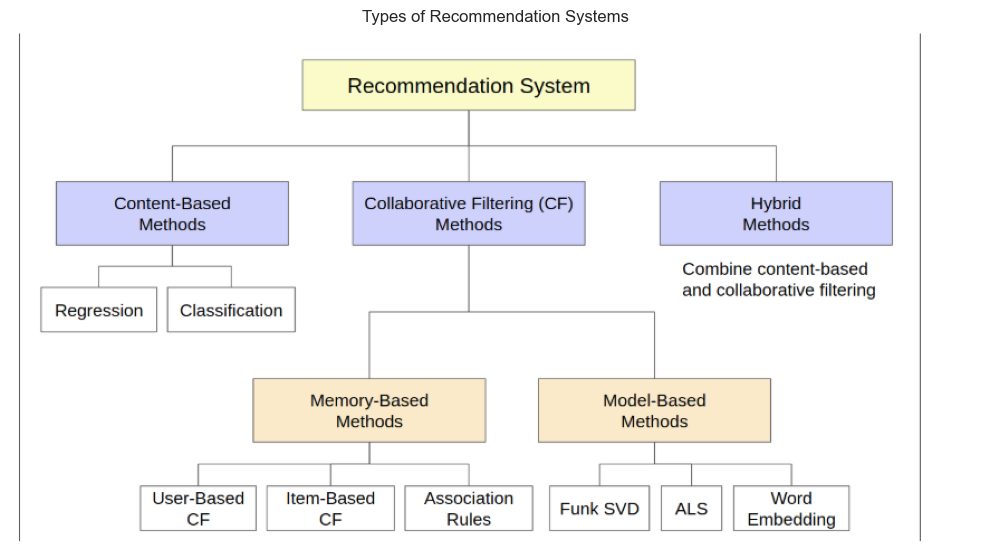

As shown in the diagram above, FunkSVD falls under the Model-Based Methods category within Collaborative Filtering approaches.


In [156]:
# Display recommendation system taxonomy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 6))
img = mpimg.imread('../data/imgs/types_of_recommendation_systems.png')
plt.imshow(img)
plt.axis('off')
plt.title('Types of Recommendation Systems')
plt.tight_layout()
plt.show()

print("As shown in the diagram above, FunkSVD falls under the Model-Based Methods category within Collaborative Filtering approaches.")

### Advantages in Recommendation Systems

FunkSVD offers several compelling advantages:
- Effectively handles extreme sparsity (often >99% missing values)
- Scales efficiently to large datasets with millions of users/items
- Naturally incorporates regularization to prevent overfitting
- Captures complex, non-obvious interaction patterns between users and items

### Our Implementation Context

For this implementation, we'll use a book rating dataset containing user preferences for various books. Each interaction includes:
- A unique User-ID
- ISBN identifiers for books
- Numerical ratings (0-10 scale) representing user preferences

By the end of this notebook, we'll have a fully functional recommendation engine capable of suggesting books that individual users are likely to enjoy based on their previous ratings and the collective wisdom of other users.

## Mathematical Foundations

### Matrix Factorization Concept

The core insight of FunkSVD is approximating a sparse rating matrix $R$ using two lower-dimensional matrices:

$$R \approx P \times Q^T$$

Where:
- $R \in \mathbb{R}^{m \times n}$ is the user-item ratings matrix (with $m$ users and $n$ items)
- $P \in \mathbb{R}^{m \times k}$ represents user factors (user latent features)
- $Q \in \mathbb{R}^{n \times k}$ represents item factors (item latent features)
- $k$ is the number of latent factors (much smaller than $m$ or $n$)

Each row $P_u$ in $P$ represents a user's preferences across $k$ hidden dimensions, while each row $Q_i$ in $Q$ represents how much an item possesses those same latent features.

### Understanding Latent Factors Intuitively

These latent factors don't necessarily correspond to explicit features we might recognize. For books, they could represent abstract concepts like:
- Emotional intensity
- Complexity of language
- Pace of narrative
- Degree of character development

The algorithm discovers these dimensions automatically without needing them to be labeled.

### FunkSVD Optimization

To find the optimal values for $P$ and $Q$, FunkSVD minimizes a loss function with regularization:

$$L = \sum_{(u,i) \in \mathcal{K}} (r_{ui} - p_u \cdot q_i)^2 + \lambda(||p_u||^2 + ||q_i||^2)$$

Where:
- $\mathcal{K}$ is the set of observed ratings
- $r_{ui}$ is the observed rating of user $u$ for item $i$
- $p_u \cdot q_i$ is the dot product of user $u$ and item $i$ factors
- $\lambda$ is the regularization parameter to prevent overfitting

The optimization uses stochastic gradient descent (SGD) with these update rules:

$$p_u \leftarrow p_u + \gamma(e_{ui} \cdot q_i - \lambda \cdot p_u)$$
$$q_i \leftarrow q_i + \gamma(e_{ui} \cdot p_u - \lambda \cdot q_i)$$

Where:
- $e_{ui} = r_{ui} - p_u \cdot q_i$ is the prediction error
- $\gamma$ is the learning rate

### Prediction and Recommendation

Once we've learned the latent factors, we can predict unknown ratings using:

$$\hat{r}_{ui} = p_u \cdot q_i$$

For practical purposes, we clip predictions to the valid rating range [0, 10].

To generate personalized recommendations for a user:
1. Calculate predicted ratings for all items the user hasn't rated
2. Rank items by their predicted ratings
3. Return the top-N items as recommendations

### Example of Matrix Factorization in Action

Let's look at an example of how our latent factor matrices work in practice. After training our model, we might end up with factor matrices like these (showing just a sample with 3 factors):

#### Item Factors (Q matrix):

```
             factor_1    factor_2    factor_3
item_1         1.26       -1.52       -0.66
item_2        -2.45        2.77       -2.93
item_3         0.45        1.59        2.24
item_4        -2.75        0.97        2.27
```

#### User Factors (P matrix):

```
             factor_1    factor_2    factor_3
user_1        -1.27        2.64        0.31
user_2         1.73       -2.73       -0.26
user_3        -0.55        0.17        2.74
user_4         2.30        2.35       -0.28
```

Suppose we want to get the rating of user_1 and item_2, which has actual rating of 9. We simply multiply the P matrix with the Q^T matrix for user_1 and item_2:

$$\hat{r} = P \cdot Q^T = [-1.27 \quad 2.64 \quad 0.31] \cdot \begin{bmatrix} -2.45 \\ 2.77 \\ -2.93 \end{bmatrix} = 9.516$$

Now we calculate the squared error of the prediction:

$$Error = (9 - 9.516)^2 = 0.266$$

This example demonstrates how our latent factors can accurately approximate user preferences.


In [145]:
# Import required libraries
import numpy as np
import pandas as pd
from utils.data_loader import *
import pickle


## Data Preparation

Before implementing FunkSVD, we need to prepare our data properly. This preparation stage is crucial for ensuring efficient training and accurate recommendations.

### Understanding the Rating Data

Our dataset consists of user-book interactions with ratings on a scale of 0-10. Each record contains:
- **User-ID**: A unique identifier for each user
- **ISBN**: A standard book identifier
- **Book-Rating**: A numerical score representing the user's preference


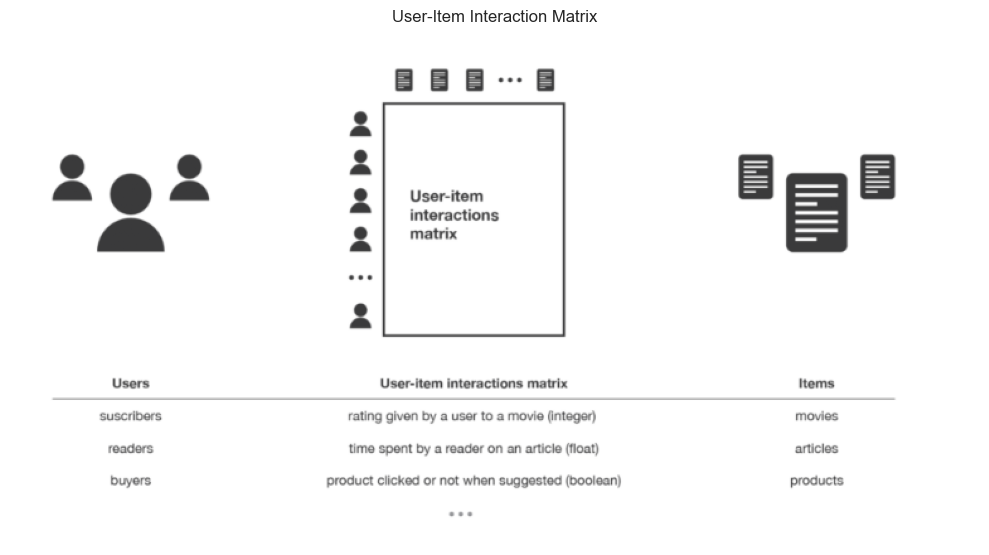

This matrix represents how users have interacted with items - whether through explicit ratings (as in our book ratings case), implicit feedback like viewing time, or binary interactions such as clicks.


In [157]:
# Display user-item interaction matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 6))
img = mpimg.imread('../data/imgs/user_item_matrix.png')  # Update with your actual filename
plt.imshow(img)
plt.axis('off')
plt.title('User-Item Interaction Matrix')
plt.tight_layout()
plt.show()

print(
    "This matrix represents how users have interacted with items - whether through explicit ratings (as in our book ratings case), implicit feedback like viewing time, or binary interactions such as clicks.")


### Creating Efficient Representations

Since user IDs and ISBNs are typically strings or non-sequential identifiers, we need to convert them to integer indices for efficient matrix operations:

1. **User and Item Mapping**:
   - `user_id_map`: Maps original user IDs to zero-indexed integer indices
   - `isbn_map`: Maps book ISBNs to zero-indexed integer indices
   - We also maintain inverse mappings to convert back when generating recommendations

2. **Handling the Sparsity Challenge**:
   - In recommendation datasets, most users have only rated a tiny fraction of items
   - Our implementation directly works with observed (user, item, rating) triplets
   - This approach avoids creating and storing the full sparse matrix

3. **Latent Factor Matrices**:
   - $P$: Size $(num\_users \times k)$ for user factors
   - $Q$: Size $(num\_books \times k)$ for book factors

Where $k$ is the dimensionality of our latent space (set to 100 by default, balancing expressiveness and computational efficiency).


In [147]:
# Load the ratings data
ratings = load_cleaned_ratings()

## FunkSVD Class Implementation

Our FunkSVD implementation is designed to be both educationally clear and practically efficient. We'll structure it as a complete class with initialization, training, prediction, and recommendation functionality.

### Hyperparameter Selection

The model is initialized with several key hyperparameters:

- **`n_factors` ($k$)**: Number of latent factors to learn (default=100)
  - Controls the expressiveness of the model
  - Higher values can capture more complex patterns but risk overfitting
  - Lower values are more efficient but may miss subtle interactions

- **`lr` ($\gamma$)**: Learning rate for gradient descent updates (default=0.02)
  - Controls how quickly the model adapts to the training data
  - Too high: may cause unstable training and overshooting
  - Too low: slow convergence and potentially getting stuck in local minima

- **`reg` ($\lambda$)**: Regularization strength (default=0.02)
  - Prevents overfitting by penalizing large factor values
  - Higher values create a more generalized model that may underfit
  - Lower values allow the model to fit training data more closely

- **`n_epochs`**: Number of complete passes through the dataset (default=70)
  - More epochs allow for better convergence but increase training time
  - The optimal value depends on dataset size and complexity

- **`random_state`**: Seed for reproducible results (default=42)

These default values have been chosen based on empirical testing with book recommendation datasets, but may require tuning for optimal performance on specific data.


In [148]:
class FunkSVD:
    def __init__(self, n_factors=100, lr=0.02, reg=0.02, n_epochs=70, random_state=42):
        """
        Initialize the FunkSVD model with hyperparameters.
        
        Parameters:
        -----------
        n_factors : int
            Number of latent factors (k)
        lr : float
            Learning rate for SGD
        reg : float
            Regularization strength
        n_epochs : int
            Number of iterations over the training data
        random_state : int
            Seed for random number generation
        """
        self.k = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.rng = np.random.default_rng(random_state)


### Training Process

The `fit` method implements the model training process, which is the core of FunkSVD:

#### 1. Factor Matrix Initialization
We initialize both $P$ and $Q$ matrices with small random values from a normal distribution $\mathcal{N}(0, 0.1)$. This initialization is important because:
- Small initial values help stabilize early training iterations
- Random initialization breaks symmetry, allowing different factors to learn different patterns
- The normal distribution provides a balanced mix of positive and negative values

#### 2. Stochastic Gradient Descent Loop
For each epoch, we:
- Randomly shuffle the training samples to prevent any learning bias from data ordering
- Process each user-item-rating triplet independently to update factor values

#### 3. Update Rules
For each observed rating, we:
- Compute the current prediction $\hat{r}_{ui} = p_u \cdot q_i$
- Calculate prediction error $e_{ui} = r_{ui} - \hat{r}_{ui}$
- Update user factors using gradient of the error with respect to user factors
- Update item factors using gradient of the error with respect to item factors

This process gradually refines the latent factors until they converge to values that minimize the overall prediction error while maintaining generalization through regularization.


In [149]:
    def fit(self, df=ratings):
        """
        Train the FunkSVD model using stochastic gradient descent.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            DataFrame containing User-ID, ISBN, and Book-Rating columns
            
        Returns:
        --------
        self : FunkSVD
            The trained model instance
        """
        # Load user and item mapping dictionaries
        maps = load_mappers()
        self.user_id_map = maps[0]
        self.isbn_map = maps[1]
        self.user_id_map_inv = maps[2]
        self.isbn_map_inv = maps[3]
        NUMBER_OF_USERS = len(self.user_id_map)
        NUMBER_OF_BOOKS = len(self.isbn_map)

        # Initialize factor matrices with small random values
        self.P = self.rng.normal(0, 0.1, (NUMBER_OF_USERS, self.k))
        self.Q = self.rng.normal(0, 0.1, (NUMBER_OF_BOOKS, self.k))

        # Convert user IDs and ISBNs to numerical indices
        users = np.asarray([self.user_id_map[u] for u in df["User-ID"]])
        isbns = np.asarray([self.isbn_map[isbn] for isbn in df["ISBN"]])
        ratings = df["Book-Rating"].to_numpy()

        # Stochastic gradient descent training loop
        for epoch in range(self.n_epochs):
            # Shuffle the data for each epoch
            idx = self.rng.permutation(len(ratings))
            
            # Process each user-item-rating triplet
            for u, i, rating in zip(users[idx], isbns[idx], ratings[idx]):
                # Calculate prediction and error
                pred = self.P[u] @ self.Q[i]  # Dot product for prediction
                err = rating - pred
                
                # Save old user factors before updating (needed for item factor update)
                P_old = self.P[u].copy()
                
                # Update user and item factors using gradient descent
                self.P[u] = self.P[u] + self.lr * (err * self.Q[i] - self.reg * self.P[u])
                self.Q[i] = self.Q[i] + self.lr * (err * P_old - self.reg * self.Q[i])

        return self


### Prediction

The `predict` method estimates how a specific user would rate a given book:

1. **Index Mapping**: First, we convert the user ID and ISBN to their corresponding internal indices using our mapping dictionaries.

2. **Rating Calculation**: We compute the dot product between the user's factor vector and the book's factor vector, which gives us the raw predicted rating: $\hat{r}_{ui} = p_u \cdot q_i$

3. **Value Clipping**: Since real ratings are bounded (in our case, between 0 and 10), we clip the prediction to ensure it stays within the valid range.

This method forms the foundation for both evaluating model performance and generating user recommendations. The dot product essentially measures how well a book's characteristics align with a user's preferences across the latent dimensions we've learned.


In [150]:
    def predict(self, user_id, isbn):
        """
        Predict the rating for a given user-item pair.
        
        Parameters:
        -----------
        user_id : str or int
            User identifier
        isbn : str
            Book ISBN identifier
            
        Returns:
        --------
        float
            Predicted rating in the range [0, 10]
        """
        # Map user and item to their internal indices
        user_indx = self.user_id_map[user_id]
        item_indx = self.isbn_map[isbn]
        
        # Calculate predicted rating using dot product
        pred_rating = self.P[user_indx] @ self.Q[item_indx]
        
        # Clip prediction to valid rating range
        if pred_rating > 10:
            pred_rating = 10
        elif pred_rating < 0:
            pred_rating = 0
            
        return float(pred_rating)


### Recommendation Generation

The `recommend` method generates personalized book recommendations for a user by leveraging the patterns learned during training:

#### The Recommendation Process

1. **Calculate Predicted Ratings**: 
   - We compute the potential rating for every book in the catalog by performing a matrix multiplication between the user's factor vector and all item factors
   - This efficient approach avoids having to calculate each prediction individually

2. **Filter Already-Rated Items**:
   - We identify books the user has already rated in the training data
   - These items are excluded from recommendations by setting their scores to negative infinity
   - This ensures we only recommend new, unexplored content to the user

3. **Rank and Select**:
   - We sort all unrated books by their predicted scores
   - We return the top-N books with the highest predicted ratings

4. **ISBN Conversion**:
   - The final step converts the internal indices back to actual ISBNs that can be used to look up book details

This approach provides a personalized ranking of books tailored to each user's unique preference profile as captured by their latent factor vector.


In [151]:
    def recommend(self, user_id, N=10, df=ratings):
        """
        Generate top-N book recommendations for a specific user.
        
        Parameters:
        -----------
        user_id : str or int
            User identifier
        N : int
            Number of recommendations to generate
        df : pandas.DataFrame
            DataFrame containing the original ratings data
            
        Returns:
        --------
        list
            List of recommended book ISBNs in descending order of predicted preference
        """
        # Get user's internal index
        user_indx = self.user_id_map[user_id]
        
        # Calculate scores for all books
        scores = self.Q @ self.P[user_indx]
        
        # Find books the user has already rated
        seen_isbns = df[df["User-ID"] == user_id]["ISBN"]
        seen_indices = [self.isbn_map[k] for k in seen_isbns]
        
        # Exclude already-rated books by setting their scores to -infinity
        scores[seen_indices] = -np.inf
        
        # Get indices of top-N scoring books
        top_n_scores_indx = np.argsort(scores)[-N:]
        
        # Convert indices back to ISBNs
        recommended_isbns = [self.isbn_map_inv[i] for i in top_n_scores_indx]
        
        # Return recommendations in descending order of preference
        return recommended_isbns[::-1]


## Model Building and Saving

Once we've implemented the FunkSVD class, we can train a model and save it for later use. This process involves:

1. **Model Initialization and Training**:
   - Create a new FunkSVD instance with desired hyperparameters
   - Fit the model on our ratings data to learn the latent factors

2. **Model Serialization**:
   - Save the trained model to disk using Python's pickle module
   - This preserves all learned parameters and mappings for future use

3. **Deployment Considerations**:
   - The serialized model can be loaded in production environments
   - This approach separates the time-consuming training process from inference

By saving the model after training, we can avoid retraining it every time we need to make recommendations, which is particularly valuable for large datasets where training can take significant time.


In [152]:
def build_trained_model(path=r'..\models\collaborative_filtering_model.pkl'):
    """
    Train and save a FunkSVD model to disk.
    
    Parameters:
    -----------
    path : str
        File path where the model will be saved
    """
    # Initialize and train the model
    model = FunkSVD()
    model.fit()
    
    # Serialize and save the model
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved successfully to {path}")
    
    return model

# Uncomment to train and save the model
# model = build_trained_model()


## Conclusion

In this notebook, we've implemented a complete FunkSVD recommender system for book ratings. Our implementation covers:

1. **Theoretical Foundations**: We've explained the mathematical principles behind matrix factorization and how FunkSVD applies them to recommendation problems.

2. **Efficient Implementation**: Our code efficiently handles the sparsity challenge inherent in recommendation data through:
   - Direct processing of observed ratings without materializing the full matrix
   - Stochastic gradient descent optimization that scales well with data size
   - Proper regularization to avoid overfitting on the sparse signals

3. **Practical Utility**: The final system can generate personalized book recommendations for any user in our dataset, potentially helping readers discover books they'll enjoy.

FunkSVD represents an elegant and effective approach to recommendation systems. By breaking down the complex user-item interaction space into learned latent dimensions, it captures subtle patterns that would be difficult to model explicitly. Our implementation demonstrates how powerful this approach can be, even with relatively straightforward code.

The principles applied here extend far beyond book recommendations and are foundational to many modern recommender systems in e-commerce, streaming media, and content platforms.